# Depression from tweets detection #

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import itertools


In [2]:
import warnings
warnings.filterwarnings("ignore")

# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '6ce0c011-aa35-4425-9b6b-e8d8d8a1b919'
resource_group = 'projekt1_grupa6'
workspace_name = 'depresja_projekt'

workspace = Workspace(subscription_id, resource_group, workspace_name)

train_data1 = Dataset.get_by_name(workspace, name='train_data1')
train_data2 = Dataset.get_by_name(workspace, name='train_data')

analysis_data = Dataset.get_by_name(workspace, name='data_no_labels2')
analysis_data = analysis_data.to_pandas_dataframe()

In [3]:
train_data1 = train_data1.to_pandas_dataframe()
train_data2 = train_data2.to_pandas_dataframe()

## Joining two train datasets ##

In [4]:
train_data2 = train_data2[['text', 'class']]

train_data1.columns = ['text','class']
train_data = pd.concat([train_data1, train_data2])

In [5]:
train_data['class'].value_counts()

non-suicide     116037
suicide         116037
depression       10371
SuicideWatch      9992
Name: class, dtype: int64

In [6]:
train_data['class'] = train_data['class'].replace(['suicide','depression',"SuicideWatch"], 1)

In [7]:
train_data['class'] = train_data['class'].replace(['non-suicide'], 0)

In [8]:
train_data['class'].value_counts()

1    136400
0    116037
Name: class, dtype: int64

# Dividing into train and test #

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_data['text'],
                                                    train_data['class'],
                                                    test_size=0.2,
                                                    random_state=0)

## Creating bag of words ##

Bag of words = matrix which consists of count how many times each word appears in tweet, so where rows means tweets, columns are equal to particular words and values are counts of each word in sentence

In [10]:
vectorizer = TfidfVectorizer(stop_words='english',
                             ngram_range=(4,7),
                             min_df=5,
                             strip_accents='unicode')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
X_train_vectorized
len(vectorizer.get_feature_names())

33442

## Classifier ##

In [11]:
def plot_confusion_matrix(cm,
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True values')
    plt.xlabel('Received values')
    plt.tight_layout()

In [12]:
def classify(classifier, vectorizer):

    classifier.fit(X_train_vectorized, y_train)

    predictions = classifier.predict(X_train_vectorized)
    print('Train Accuracy: ', accuracy_score(y_train, predictions))
    cm = confusion_matrix(y_train, predictions)
    print(cm)

    predictions = classifier.predict(X_test_vectorized)
    print('Test Accuracy: ', accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cm,
                          classes=[0, 1],
                          title="Classification matrix - Validation")
    print("Raport klasyfikacji: ")
    print(classification_report(y_test, predictions))
    print(cm)

In [13]:
def find_best_features(classifier, vactorizer):
    feature_names = np.array(vectorizer.get_feature_names())
    sorted_coef_index = classifier.coef_[0].argsort()
    print('Smallest Coefs:\n{}\n'.format(
        feature_names[sorted_coef_index[:10]]))
    print('Largest Coefs: \n{}'.format(
        feature_names[sorted_coef_index[:-11:-1]]))

Train Accuracy:  0.6769184299006185
[[89796  3027]
 [62219 46907]]
Test Accuracy:  0.6502733322769767
Raport klasyfikacji: 
              precision    recall  f1-score   support

           0       0.57      0.96      0.72     23214
           1       0.92      0.38      0.54     27274

    accuracy                           0.65     50488
   macro avg       0.75      0.67      0.63     50488
weighted avg       0.76      0.65      0.62     50488

[[22350   864]
 [16793 10481]]


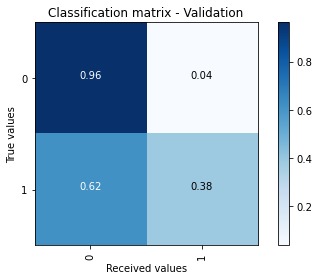

In [14]:
classifier_log = LogisticRegression(class_weight="balanced")
classify(classifier_log, vectorizer)

In [15]:
find_best_features(classifier_log,  vectorizer)

Smallest Coefs:
['filler filler filler filler' 'https www twitch tv'
 'https open spotify com' 'https www youtube com' 'thank coming ted talk'
 'posting everyday girlfriend day' 'thanks coming ted talk'
 'filler filler filler filler filler' 'writing positive happened today'
 'https www reddit com teenagers']

Largest Coefs: 
['don want live anymore' 'want die just want' 'http www reddit com'
 'don want alive anymore' 'just want pain stop' 'don want hurt family'
 'make look like accident' 'want die don want' 'just want sleep wake'
 'don really want die']


In [16]:
analysis_data.head()
X_test = analysis_data['text']
X_test_vectorized = vectorizer.transform(X_test)

In [17]:
predictions = classifier_log.predict(X_test_vectorized)

In [18]:
analysis_data['depression_pred'] = predictions
analysis_data['depression_pred'].value_counts()

0    20016
1       34
Name: depression_pred, dtype: int64

In [19]:
depression_tweets = analysis_data.loc[analysis_data['depression_pred'] == 1][['gender','text']]

In [20]:
pd.set_option('display.max_colwidth', -1)
depression_tweets

,gender,text
150,brand,"FFS, i don't know if im going to love Simple Plan's new album, like the songs iv heard from it from it so far are meh and im like o sht noo."
408,female,Andddd I've lost count of how many times I've already watched the @AlmostAdultsMov trailer......someone help meeeeeeeeee
694,male,"Yknow what, I'm so damn done. Want me, don't want me, I don't care, miss me or don't, don't care, cya later."
1279,male,So hard to be positive when life isn't going the way you planned
1791,male,"Some people just do whatever they feel like to get whatever they want, and don't even care about the people they step on in the process"
2099,male,"@leezasesteaga aww don't feel sad,.its just some ppl are fucked up in the head&amp; fuck over the wrong ppl without noticing it"
2220,female,I shouldn't even feel this way but I just do... I'm so lonely all the time
2927,brand,"@jaybeware Sure, but at the end of the day, I feel like defendant should have more say in who are their peers than judge"
3424,brand,"gmgilmore: Life with an almost 12 year old daughter. I'm the coolest one minute, the worst the next. #tween #parenting"
3754,male,Just caught up on the news via twitter. Don't think I'll come back. Off out now to drink wine in a country that goes on strike all the time.
